In [ ]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

## 1. EDA

In [ ]:
data = pd.read_csv("comments_data.csv", encoding='utf-8')
data.head()

,Comment,Sentiment
0,here in nz 50 of retailers don’t even have con...,negative
1,i will forever acknowledge this channel with t...,positive
2,whenever i go to a place that doesn’t take app...,negative
3,apple pay is so convenient secure and easy to ...,positive
4,we only got apple pay in south africa in 20202...,positive


In [ ]:
data['Sentiment'] = data['Sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
data["Sentiment"].value_counts()

,count
Sentiment,
1,11432
0,2338


In [ ]:
null_values = data.isnull()
null_values.sum()

,0
Comment,31
Sentiment,0


In [ ]:
data=data.dropna()

In [ ]:
# Checking for duplicates
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())


Number of duplicate rows: 368


In [ ]:
data=data.drop_duplicates()

In [ ]:
# example_text = data["Comment"][4]
# example_text

#### 1.1 Data cleaning

In [ ]:
def clean_text(text):

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove additional HTML-like patterns
    text = re.sub(r'<.*?>', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the cleaning function
data['cleaned_comments'] = data['Comment'].apply(clean_text)
data.to_csv("comments_data.csv", index=False)

In [ ]:
example = data["Comment"][50]

print(example)
print(' ')
print(data['cleaned_comments'][50])

hey something that might interest you a couple of days ago my amazon account was closed with no warning for after hours of wasted time theyre telling me its for excessive returns which i think is an error but thats beside the point when they closed my amazon account all my amazon devices that i own for years primarily all my echo devices stopped working i lost access to the amazon photos and prime video which i pay for so apparently the devices you already own are subject to be disabled by amazon on your perceived shopping habits i assume the same applies to all other amazon devices and services like fire os tablets ring cameras and probably aws as well just wanted to make other people aware of this because they definitely dont tell you this when you buy your hardware and services
 
hey something that might interest you a couple of days ago my amazon account was closed with no warning for after hours of wasted time theyre telling me its for excessive returns which i think is an error b

/tmp/ipython-input-2103583781.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=data, palette="viridis")


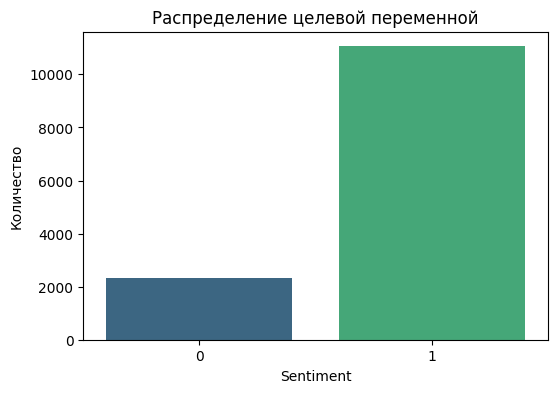

In [ ]:

import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=data, palette="viridis")
plt.title('Распределение целевой переменной')
plt.xlabel("Sentiment")
plt.ylabel("Количество")
plt.show()


In [ ]:
# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Tokenization and Lemmatization
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)  # Tokenization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return ' '.join(lemmatized_tokens)

# Process the reviews
data['processed_comments'] = data['cleaned_comments'].apply(tokenize_and_lemmatize)

Comments:

## 2. Data Visualization

Wordclouds

In [ ]:
!pip install wordcloud

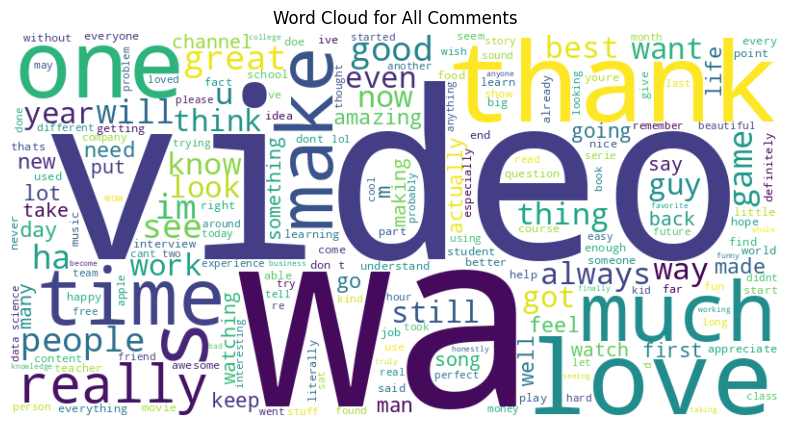

In [ ]:
from wordcloud import WordCloud

# Word Cloud for all reviews
all_reviews = ' '.join(data['processed_comments'])
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Comments')
plt.show()

Adding length column

In [ ]:
data['comments_length'] = data['processed_comments'].apply(lambda x: len(x.split()))
data.head()

,Comment,Sentiment,cleaned_comments,processed_comments,comments_length
0,here in nz 50 of retailers don’t even have con...,0,here in nz of retailers don’t even have contac...,here in nz of retailer don ’ t even have conta...,32
1,i will forever acknowledge this channel with t...,1,i will forever acknowledge this channel with t...,i will forever acknowledge this channel with t...,31
2,whenever i go to a place that doesn’t take app...,0,whenever i go to a place that doesn’t take app...,whenever i go to a place that doesn ’ t take a...,99
3,apple pay is so convenient secure and easy to ...,1,apple pay is so convenient secure and easy to ...,apple pay is so convenient secure and easy to ...,26
4,we only got apple pay in south africa in 20202...,1,we only got apple pay in south africa in and i...,we only got apple pay in south africa in and i...,15


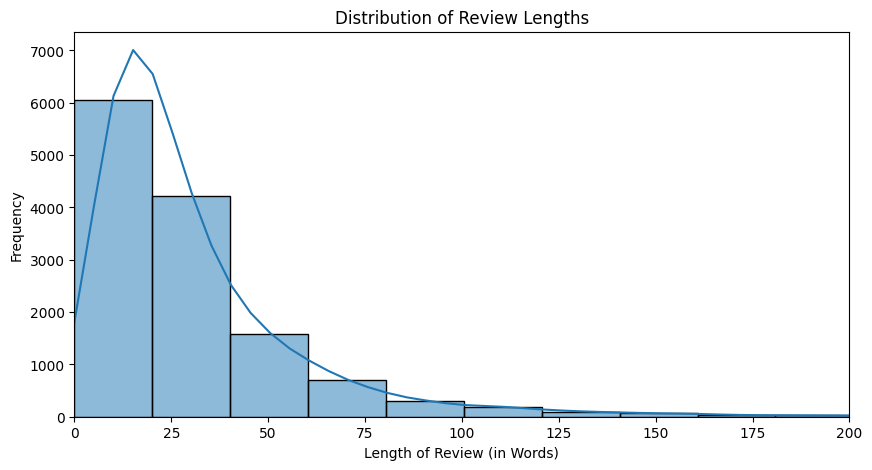

In [ ]:
# Visualize Review Length Distribution
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.xlim(0, 200)  # keep only up to 200 words on x-axis
sns.histplot(data['comments_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review (in Words)')
plt.ylabel('Frequency')
plt.show()

Comments:

## 3. Vectorization

In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Загружаем CSV
df = pd.read_csv("comments_data.csv")

# Фичи и таргет
X = data["processed_comments"].astype(str)   # тексты
y = data["Sentiment"]                        # метки

# Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.to_numpy().reshape(-1, 1), y)

# Превращаем обратно в DataFrame
df_balanced = pd.DataFrame({
    "processed_comments": X_resampled.flatten(),
    "Sentiment": y_resampled
})

print(df_balanced["Sentiment"].value_counts())

#balancing the data

Sentiment
0    11054
1    11054
Name: count, dtype: int64


In [ ]:
# Vectorization using Bag of Words (BoW)
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['processed_comments'])
y = data['Sentiment']

# Split the data for BoW
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_comments'])

# Split the data for TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

Comments:

## 4. Model building and evaluation

In [ ]:
from sklearn.svm import SVC

In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=20, n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear')
}


# Store results
results = {
    "BoW": {},
    "TF-IDF": {}
}

# Function to train and evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, vectorization_method):

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[vectorization_method][model_name] = {
            "Accuracy": accuracy,
            "Precision": report['weighted avg']['precision'],
            "Recall": report['weighted avg']['recall'],
            "F1 Score": report['weighted avg']['f1-score']
        }

        print(f"{model_name} was trained")


In [ ]:
# Evaluate models using BoW
evaluate_models(X_train_bow, X_test_bow, y_train, y_test, "BoW")

Logistic Regression was trained
Random Forest was trained
Naive Bayes was trained
Support Vector Machine was trained


In [ ]:
# Evaluate models using TF-IDF
evaluate_models(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

Logistic Regression was trained
Random Forest was trained
Naive Bayes was trained
Support Vector Machine was trained


In [ ]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame({(i, j): results[i][j] for i in results.keys() for j in results[i].keys()})
results_df = results_df.T

results_df

Accuracy  Precision    Recall  F1 Score
BoW    Logistic Regression     0.893832   0.887795  0.893832  0.885540
       Random Forest           0.840374   0.831881  0.840374  0.793744
       Naive Bayes             0.883738   0.875916  0.883738  0.876554
       Support Vector Machine  0.887850   0.882471  0.887850  0.884118
TF-IDF Logistic Regression     0.859065   0.858180  0.859065  0.826850
       Random Forest           0.838131   0.846273  0.838131  0.782965
       Naive Bayes             0.819813   0.762973  0.819813  0.741448
       Support Vector Machine  0.888224   0.882825  0.888224  0.876112

Two best models are (as they have higher F1 score)
1. Bag-of-Words + Logistic Regression
2. Bag-of-Words + Support Vector Machine

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, f1_score

# --- 1. Данные ---
X = df["cleaned_comments"]   # тексты
y = df["Sentiment"]          # метки (0/1)

# --- 2. Пайплайны ---
logreg_pipeline = Pipeline([
    ("bow", CountVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

svm_pipeline = Pipeline([
    ("bow", CountVectorizer()),
    ("clf", SVC(random_state=42))
])

# --- 3. Гриды гиперпараметров ---
logreg_param_grid = {
    "bow__ngram_range": [(1,1), (1,2)],          # униграммы vs уни+би
    "clf__C": [0.01, 0.1, 1, 10],                # регуляризация
    "clf__penalty": ["l2"],                      # только L2
    "clf__solver": ["lbfgs", "liblinear"]        # разные решатели
}

svm_param_grid = {
    "bow__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.1, 1, 10],
    "clf__kernel": ["linear", "rbf"]             # разные ядра
}

# --- 4. Оптимизация через GridSearchCV ---
scorer = make_scorer(f1_score, average="binary")

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid,
                           cv=5, scoring=scorer, n_jobs=-1, verbose=1)
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid,
                        cv=5, scoring=scorer, n_jobs=-1, verbose=1)

# --- 5. Обучение и подбор ---
print("=== Logistic Regression (Bag-of-Words) ===")
logreg_grid.fit(X, y)
print("Лучшие гиперпараметры:", logreg_grid.best_params_)
print("Лучший F1-score:", logreg_grid.best_score_)

print("\n=== Support Vector Machine (Bag-of-Words) ===")
svm_grid.fit(X, y)
print("Лучшие гиперпараметры:", svm_grid.best_params_)
print("Лучший F1-score:", svm_grid.best_score_)



=== Logistic Regression (Bag-of-Words) ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие гиперпараметры: {'bow__ngram_range': (1, 1), 'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Лучший F1-score: 0.932635337335596

=== Support Vector Machine (Bag-of-Words) ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие гиперпараметры: {'bow__ngram_range': (1, 1), 'clf__C': 10, 'clf__kernel': 'rbf'}
Лучший F1-score: 0.9297425663673415


 Logistic Regression (Bag-of-Words) лучше. Так как F1 выше (0.932635337335596)

> Add blockquote



# Part-2 - Using pre-trained models

Refer to P7-2 file

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
dataset = load_dataset("csv", data_files="comments_data.csv")


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Load the tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    texts = [str(t) for t in examples["cleaned_comments"]]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

# Обрабатываем именно dataset["train"]
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/13371 [00:00<?, ? examples/s]

In [ ]:
# def analyze_sentiment(text):
#     result = sentiment_pipeline(text)[0]   # вернёт dict
#     return pd.Series({
#         "sentiment_label": result["label"],
#         "sentiment_score": result["score"]
#     })

# df[["sentiment_label", "sentiment_score"]] = df["cleaned_comments"].apply(analyze_sentiment)
from transformers import pipeline

# Создаём пайплайн с усечением
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,
    max_length=512
)

def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return pd.Series({
        "sentiment_label": result["label"],
        "sentiment_score": result["score"]
    })

df[["sentiment_label", "sentiment_score"]] = df["cleaned_comments"].astype(str).apply(analyze_sentiment)


Device set to use cpu


In [ ]:
sample = pd.DataFrame({
    "review": data["cleaned_comments"][:5],
    "sentiment": data["Sentiment"][:5]
})

print(sample)


                                              review  sentiment
0  here in nz of retailers don’t even have contac...          0
1  i will forever acknowledge this channel with t...          1
2  whenever i go to a place that doesn’t take app...          0
3  apple pay is so convenient secure and easy to ...          1
4  we only got apple pay in south africa in and i...          1


In [ ]:
# Берем тексты для анализа (список строк)
sample_reviews = data["cleaned_comments"][:5].tolist()

# Запускаем анализ
predictions = sentiment_pipeline(sample_reviews)  # это список словарей

# Достаём метки и confidence
labels = [pred["label"] for pred in predictions]
scores = [pred["score"] for pred in predictions]

# Выводим
for review, sentiment, score in zip(sample_reviews, labels, scores):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment} (score={score:.4f})\n")



Review: here in nz of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these
Predicted Sentiment: NEGATIVE (score=0.9924)

Review: i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth
Predicted Sentiment: POSITIVE (score=0.9995)

Review: whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket
Predicted Sentiment: NEGATIVE (score=0.9996)

Review: apple pay is so convenient secure 

In [ ]:

from transformers import pipeline
from datasets import load_dataset

# # Загружаем CSV в формате HuggingFace
# dataset = load_dataset("csv", data_files="comments_data.csv")["train"]

# # Создаём пайплайн
# sentiment_pipeline = pipeline(
#     "sentiment-analysis",
#     model="distilbert-base-uncased-finetuned-sst-2-english",
#     device=-1,   # CPU (-1), или 0 если есть GPU
#     truncation=True,
#     max_length=128
# )

import pandas as pd
from transformers import pipeline
from datasets import load_dataset
from tqdm.auto import tqdm

# Load the IMDb dataset
dataset = load_dataset("csv", data_files="comments_data.csv")["train"]

# Prepare the sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0,  # Use GPU if available
    truncation=True,
    max_length=512
)

Device set to use cpu


In [ ]:
# Убедимся, что в колонке только строки и нет NaN
df["cleaned_comments"] = df["cleaned_comments"].fillna("").astype(str)

# Прогоняем все комментарии через модель
sentiment_results = sentiment_pipeline(df["cleaned_comments"].tolist())

# Превращаем в DataFrame
all_comments = pd.DataFrame(sentiment_results)

# Добавляем сами тексты
all_comments["cleaned_comments"] = df["cleaned_comments"].values

# Переводим метки в числа
sentiment_mapping = {"NEGATIVE": 0, "POSITIVE": 1}
all_comments["sentiment"] = all_comments["label"].map(sentiment_mapping)

print(all_comments.head())



      label     score                                   cleaned_comments  \
0  NEGATIVE  0.992369  here in nz of retailers don’t even have contac...   
1  POSITIVE  0.999452  i will forever acknowledge this channel with t...   
2  NEGATIVE  0.999628  whenever i go to a place that doesn’t take app...   
3  POSITIVE  0.966205  apple pay is so convenient secure and easy to ...   
4  POSITIVE  0.999357  we only got apple pay in south africa in and i...   

   sentiment  
0          0  
1          1  
2          0  
3          1  
4          1  


In [ ]:
all_comments

,label,score,actual,predicted


In [ ]:

import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Реальные метки (они уже 0 и 1)
actual_labels = df["Sentiment"]

# 2. Предсказания модели
predictions = sentiment_pipeline(df["cleaned_comments"].tolist())
all_comments = pd.DataFrame(predictions)

# 3. Маппинг только для предсказаний
sentiment_mapping = {"NEGATIVE": 0, "POSITIVE": 1}
all_comments["predicted"] = all_comments["label"].map(sentiment_mapping)

# 4. Добавляем реальные метки
all_comments["actual"] = actual_labels.values

# 5. Убираем строки с NaN (на всякий случай)
all_comments = all_comments.dropna(subset=["actual", "predicted"])

# 6. Метрики
accuracy = accuracy_score(all_comments["actual"], all_comments["predicted"])
precision, recall, f1, _ = precision_recall_fscore_support(
    all_comments["actual"], all_comments["predicted"], average="binary"
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8275
Precision: 0.9721
Recall: 0.8146
F1 Score: 0.8864


Comments:

# Comparison

Compare metrics results of ML model and pre-trained model

In [ ]:
 Logistic Regression (Bag-of-Words) F1 (0.932635337335596) показывает лучше результат чем  BERT F1 Score (0.8864).

BERT:
Учитывает контекст и порядок слов.
Высокая точность (Precision = 0.97). Recall ниже (0.81), пропускает часть примеров. Требует много ресурсов и дообучения.
Logistic Regression (Bag-of-Words):
Простая, быстрая и интерпретируемая. Более высокий F1 (0.93) → лучше сбалансирована Precision/Recall Не понимает контекст и порядок слов

Comments: